# Who survives in the titanic?

> Aim of this notebook is to practice coding in python and ML classification techniques

From a top level, this will follow the workflow: 

    1. Data exploration
    2. Feature engineering
    3. Train ML model 
    4. Predict using ML model 
    5. Evaluate predictions

In [1]:
import pandas as pd
import numpy as np

from scipy import stats

# Regular expressions
import re

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import maxabs_scale

# ML model training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn import metrics 

## Data exploration

In [2]:
# load in the data and overview of the data structure
train = pd.read_csv("/Users/DZ_laptop/Dropbox/DZ_Work/kaggle/getting_started_kaggle/titanic/raw_data/train.csv")
test = pd.read_csv("/Users/DZ_laptop/Dropbox/DZ_Work/kaggle/getting_started_kaggle/titanic/raw_data/test.csv")

In [3]:
print(train.shape) # what are the dimensions/number of training examples?
train.head() # what features do we have?

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# combine train and test together to use all the most data possible for feature exploration/engineering
data = pd.concat([train, test], sort = True).reset_index(drop = True)

### Which columns have missing variables?

In [6]:
for col in data.columns:
    
    print("{} has {} missing values".format(col, str(data[col].isna().sum())))

Age has 263 missing values
Cabin has 1014 missing values
Embarked has 2 missing values
Fare has 1 missing values
Name has 0 missing values
Parch has 0 missing values
PassengerId has 0 missing values
Pclass has 0 missing values
Sex has 0 missing values
SibSp has 0 missing values
Survived has 418 missing values
Ticket has 0 missing values


### Correlation between numeric features

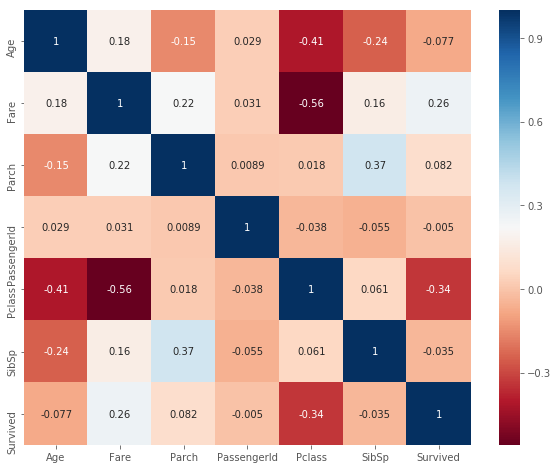

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr("pearson"), 
            cmap = "RdBu", 
            annot = True)

- Fare and Pclass stand out as correlated with the output variable survival. Intuitively, richer passengers are likely to have a greater likelihood of survival. 

## Feature engineering

### Sex

count     1309
unique       2
top       male
freq       843
Name: Sex, dtype: object
Sex
female    466
male      843
Name: PassengerId, dtype: int64
Sex     Survived
female  0.0          81
        1.0         233
male    0.0         468
        1.0         109
Name: PassengerId, dtype: int64


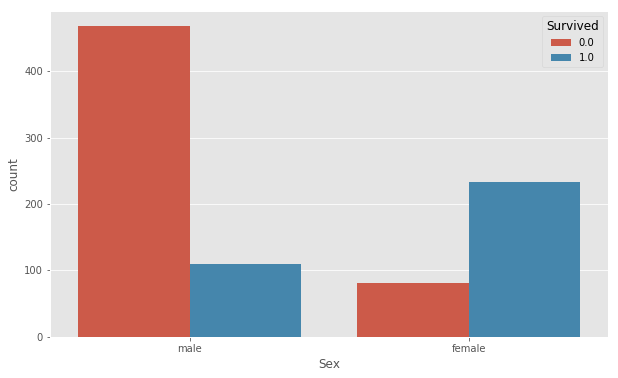

In [8]:
print(data["Sex"].describe())
print(data.groupby("Sex").PassengerId.count())
print(data.groupby(["Sex", "Survived"]).PassengerId.count()) # a much higher proportion of F survived

plt.figure(figsize=(10, 6))
sns.countplot(x = "Sex", hue = "Survived", data = data) # Looks like an important feature 
data["Sex"] = LabelEncoder().fit_transform(data["Sex"]) # convert Sex to numeric 1/0s

- Based on the count plot, it looks as though females have a higher likelihood of survival. Perhaps they were preferentially offered to leave the ship first

### Name

- Each name is labelled with a title. This may inform both the gender of the person, as well as the age and the status/wealth, all factors that may affect survival

In [9]:
# extract title from names
data["Title"] = data["Name"].apply(lambda name: re.sub(".*, ", "", name)).apply(lambda name: re.sub("\\..*", "", name))
data["Title"] = data["Title"].apply(lambda title: "Miss" if title == "Ms" else title) # convert 2 Ms to Miss
data["Title"] = data["Title"].apply(lambda title: "other" if title not in ["Master", "Miss", "Mr", "Mrs", "Ms"] else title) # group "other" 

data.groupby("Title").Name.count()

Title
Master     61
Miss      262
Mr        757
Mrs       197
other      32
Name: Name, dtype: int64

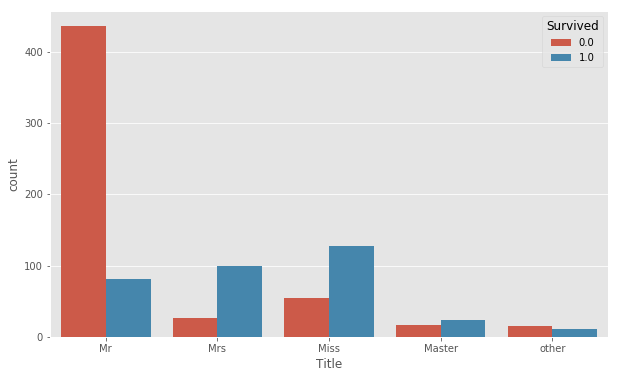

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x = "Title", hue = "Survived", data = data) # again looks informative for survival, with females disproportionately saved

In [11]:
# Encode the title data to integer - perhaps better as dummy? 
data["Title"] = LabelEncoder().fit_transform(data["Title"])
data = data.drop(columns = "Name") # remove the name variable

### Age

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


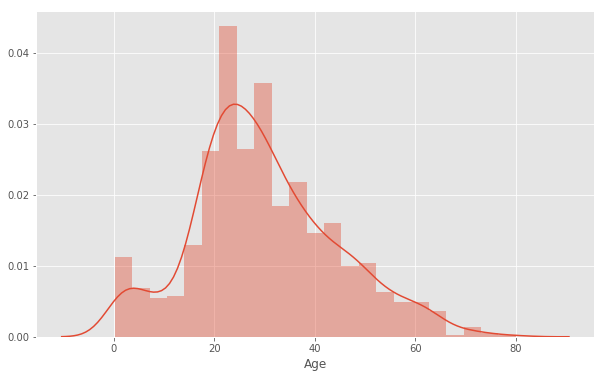

In [12]:
print(data["Age"].describe()) 
plt.figure(figsize=(10, 6))
sns.distplot(data["Age"][data["Age"].notna()]) # plot the non-NAs 

In [13]:
data.corr()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
Age,1.000000,0.178740,-0.150917,0.028814,-0.408106,0.063645,-0.243699,-0.077221,0.509109
Fare,0.178740,1.000000,0.221539,0.031428,-0.558629,-0.185523,0.160238,0.257307,0.029900
Parch,-0.150917,0.221539,1.000000,0.008942,0.018322,-0.213125,0.373587,0.081629,-0.088875
PassengerId,0.028814,0.031428,0.008942,1.000000,-0.038354,0.013406,-0.055224,-0.005007,0.039751
Pclass,-0.408106,-0.558629,0.018322,-0.038354,1.000000,0.124617,0.060832,-0.338481,-0.219885
Sex,0.063645,-0.185523,-0.213125,0.013406,0.124617,1.000000,-0.109609,-0.543351,0.014544
SibSp,-0.243699,0.160238,0.373587,-0.055224,0.060832,-0.109609,1.000000,-0.035322,-0.194396
Survived,-0.077221,0.257307,0.081629,-0.005007,-0.338481,-0.543351,-0.035322,1.000000,-0.058000
Title,0.509109,0.029900,-0.088875,0.039751,-0.219885,0.014544,-0.194396,-0.058000,1.000000


- Age is most correlated with the Title feature. Let's use the title to fill in the missing ages

In [ ]:
# fill in column with grouped mean of another column
def fill_na_col(data, col_to_fill, group_col):
    
    grouped_mean = data.groupby(group_col).Age.mean()

    col_filled = list()

    for i in range(len(data)):
    
        if np.isnan(data.iloc[i][col_to_fill]):

            col_filled.append(grouped_mean[data.iloc[i][group_col]])

        else:

            col_filled.append(data.iloc[i][col_to_fill])
    
    data[col_to_fill] = col_filled
    
    return data
    
data = fill_na_col(data = data, col_to_fill = "Age", group_col = "Title")

### SibSp & Parch

- **SibSp** is the number of siblings also aboard the titanic
- **Parch** is the number of Parents/Children

In [ ]:
print(data.groupby("Parch").Sex.count())
print(data.groupby("SibSp").Sex.count())

Parch
0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: Sex, dtype: int64
SibSp
0    891
1    319
2     42
3     20
4     22
5      6
8      9
Name: Sex, dtype: int64


In [ ]:
# 1/2 are weighted by the children, since they have either 1/2 parents on board, as you can also see from the lower ages
print(data.groupby("Parch").Age.min()) 

Parch
0     5.000000
1     0.420000
2     0.170000
3    16.000000
4    29.000000
5    38.000000
6    40.000000
9    32.252151
Name: Age, dtype: float64


In [ ]:
# Using both the Age and the Parch, let's reclassify these as child vs parents
data["child"] = data.apply(lambda row: 1 if (row.Age <= 15) and (row.Parch < 3) else 0, axis = 1)
data["parent"] = data.apply(lambda row: 1 if (row.Age >= 22) and (row.Parch > 0) else 0, axis = 1)
data["single"] = data.apply(lambda row: 1 if (row.SibSp + row.Parch) == 0 else 0, axis = 1)

data[["child", "parent", "single", "Survived"]].corr()

,child,parent,single,Survived
child,1.000000,-0.118887,-0.343796,0.136884
parent,-0.118887,1.000000,-0.455463,0.094018
single,-0.343796,-0.455463,1.000000,-0.203367
Survived,0.136884,0.094018,-0.203367,1.000000


### Pclass

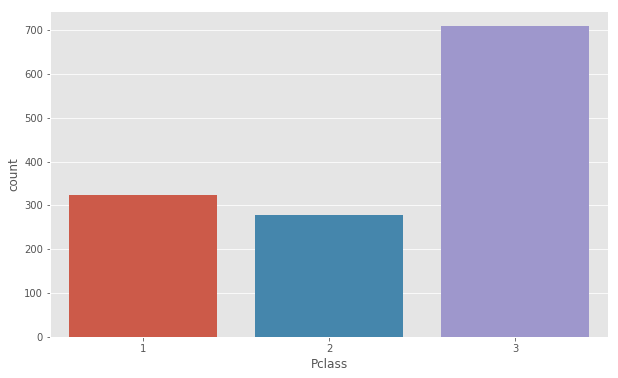

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data["Pclass"])

### Fare

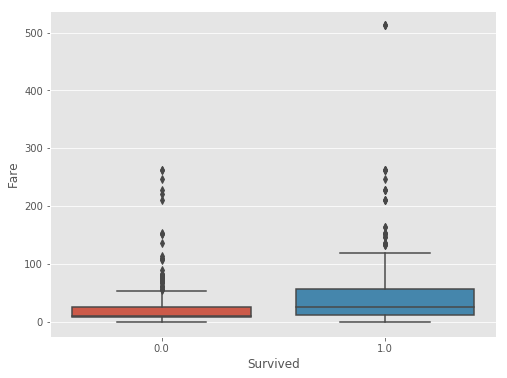

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data["Survived"], data["Fare"])

In [ ]:
data[data["Fare"].isna()] # missing row

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,child,parent,single
1043,60.5,NaN,S,NaN,0,1044,3,1,0,NaN,3701,2,0,0,1


In [ ]:
# fill in the missing line with the mean of dependent on Pclass
data["Fare"] = data.apply(lambda row: data.groupby("Pclass").Fare.mean()[row.Pclass] if np.isnan(row.Fare) else row.Fare, axis = 1)

### Embarked

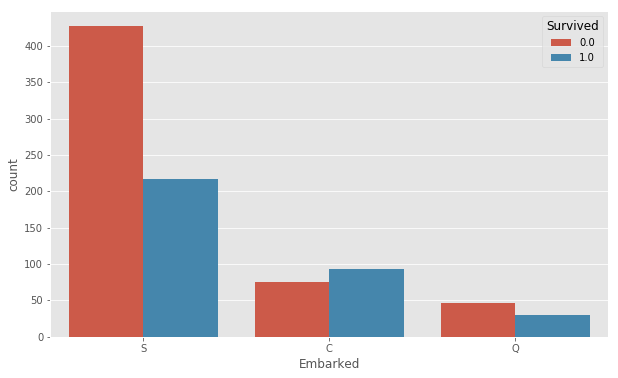

In [ ]:
# S embarking seems to have detrimental effect on survival
plt.figure(figsize=(10, 6))
sns.countplot(x = "Embarked", data = data, hue = "Survived")

In [ ]:
# S is not the least expensive on average
print(data.groupby("Embarked").Fare.mean())
data.groupby(["Embarked", "Pclass"]).PassengerId.count()

Embarked
C    62.336267
Q    12.409012
S    27.403380
Name: Fare, dtype: float64


Embarked  Pclass
C         1         141
          2          28
          3         101
Q         1           3
          2           7
          3         113
S         1         177
          2         242
          3         495
Name: PassengerId, dtype: int64

In [ ]:
data[data.Embarked.isna()]

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,child,parent,single
61,38.0,B28,NaN,80.0,0,62,1,0,0,1.0,113572,1,0,0,1
829,62.0,B28,NaN,80.0,0,830,1,0,0,1.0,113572,3,0,0,1


In [ ]:
# Based on both Fare and class let's fill the NA's in with C's
data.Embarked = data.Embarked.apply(lambda x: "C" if pd.isnull(x) else x)

In [ ]:
# Make Embarked a dummy variable 
data = pd.concat([data, pd.get_dummies(data.Embarked)], axis = 1)
data = data.drop(columns = "Embarked")

### Ticket, Cabin

- These variables look uninformative in terms of predicting survival.
    - Ticket seems like it would require severe wrangling to obtain any patterns or ML processable data
    - Cabin has many missing values

In [ ]:
data = data.drop(columns = ["Ticket", "Cabin"])

## Train ML model

### Split data back into train/test/valid

In [ ]:
# convert Age/Fare to min max of -1 to +1
# in particular, the svm requires the features to be scaled
data[["Age", "Fare"]] = maxabs_scale(data[["Age", "Fare"]])

In [ ]:
# split data back into train and test 
train = data[data.Survived.notna()]
train = train.drop(columns = "PassengerId")
test = data[data.Survived.isna()]

In [ ]:
# split the train into train and validation datasets 
# validation to get a local estimate of ML model performance
train, valid = train_test_split(train, # DataFrame to split
                                      test_size = 0.2, # proportion to split 
                                      random_state = 32) 
print(train.shape)
print(valid.shape)

(712, 14)
(179, 14)


### Ensembling

- The idea of ensembling is to combine predictions from different ML models to improve the accuracy of the overall model. In fact, a random forest is already an ensemble of decision trees. 
- Let's practice ensembling together different ML methods. To try a boost the performance of the ML models by masking their invidual errors: 
    1. For comparison, train several machine learning models both with hyperparameter tuning and without. 
    2. Predict on validation dataset then evaluate these predictions
    3. Use a ensemble based voting system to aggregate together the predictions 

In [ ]:
# initiate dictionatary of classifiers we would like to try
ensemble = {"lr" : LogisticRegression(solver = "lbfgs"), 
            "rf" : RandomForestClassifier(n_estimators = 100), 
            "svm" : SVC(probability = True), 
            "knn": KNeighborsClassifier()}

# generate a grid of hyperparamters to test for each model
# honestly, the range of these parameters seems like a fumble in the dark
# informed from online examples and from manual
ensemble_random_grid = {"lr": {"C": [0.2, 0.4, 0.6, 0.8, 1], 
                              "max_iter": [1000, 10000]},
                       "rf": {'n_estimators': [100, 250, 500],
                              'max_features': ["auto", "log2"],
                              'max_depth': [10, 25, 50, 100, None],
                              'min_samples_split': [2, 5, 10],
                              'min_samples_leaf': [1, 2, 4]}, 
                       "svm": {"kernel": ["rbf"], 
                               "gamma": [0.1, 1, 10, 100], 
                               "C": [0.1, 1, 10, 100, 1000]}, 
                       "knn": {"n_neighbors": list(range(2, 30, 2)), 
                              "p": [1, 2, 3, 4, 5]}}

In [ ]:
def tune_ensemble(X, y, ensemble, ensemble_grid = None, n_jobs = 1, random_state = 32):
    
    """For all ML models within the ensemble, does grid hyperparam tuning
    based on params detailed in the accompanying grid"""
    
    ensemble_tuned = dict()

    for clf in ensemble: 

        print("Training " + clf +  "...")
        
        if ensemble_grid is None:
            
            ensemble[clf].fit(X = X, y = y, n_jobs = n_jobs, random_state = random_state)
            
            ensemble_tuned[clf] = ensemble[clf]
        
        else: 
            
            print("Using hyperparamter grid...")
            
            clf_random = GridSearchCV(estimator = ensemble[clf], 
                                      param_grid = ensemble_grid[clf], 
                                      cv = 5, 
                                      n_jobs = n_jobs)

            clf_random.fit(X = X, y = y)

            ensemble_tuned[clf] = clf_random
            
    return ensemble_tuned

ensemble_tuned = tune_ensemble(X = train.drop(columns = "Survived"), 
                                y = train["Survived"], 
                                ensemble = ensemble, 
                                ensemble_grid = ensemble_random_grid, 
                                n_jobs = 4) 


Training lr...
Using hyperparamter grid...
Training rf...
Using hyperparamter grid...
Training svm...
Using hyperparamter grid...


In [ ]:
def pred_ensemble(X, ensemble_tuned):
    
    """Obtains a pandas dataframe of predictions from each ML model within the ensemble"""
    
    preds = dict()
    preds_prob = dict()
    
    for clf in ensemble_tuned:
    
        preds[clf + "_pred"] = ensemble_tuned[clf].predict(X = X)
        preds_prob[clf + "_prob"] = [class_proba[1] for class_proba in ensemble_tuned[clf].predict_proba(X = X)]
    
    ensemble_pred_probs = pd.concat([pd.DataFrame(preds), pd.DataFrame(preds_prob)], axis = 1)
        
    return ensemble_pred_probs

def vote_ensemble(ensemble_pred_probs):
    
    """Does a mode based (highest class frequency) and average based (mean of the prediction 
    probabilities then applied 0.5 threshold) vote to obtain the ensemble predictions"""
    
    pred_cols = [("pred" in col) for col in ensemble_pred_probs.columns]

    ensemble_pred_probs["mode_pred"] = ensemble_pred_probs[ensemble_pred_probs.columns[pred_cols]].\
    apply(lambda row: stats.mode(row)[0][0], axis = 1)
    
    pred_proba_cols = [("prob" in col) for col in ensemble_pred_probs.columns]
    
    ensemble_pred_probs["average_prob"] = ensemble_pred_probs[ensemble_pred_probs.columns[pred_proba_cols]].\
    apply(lambda row: np.mean(row), axis = 1)
    ensemble_pred_probs["average_pred"] = ensemble_pred_probs["average_prob"].apply(lambda x: 1.0 if x >= 0.5 else 0.0)
    
    return ensemble_pred_probs

ensemble_pred_probs = pred_ensemble(X = valid.drop(columns = "Survived"), 
                                    ensemble_tuned = ensemble_tuned)

ensemble_pred_probs = vote_ensemble(ensemble_pred_probs)

ensemble_pred_probs.head()

- Some of the models in the ensemble have highly correlated predictions. There may be potential to improve accuracy of ensemble predictions by dropping models that are highly correlated or weighting the votes, but it's not something I will play with here. 

In [ ]:
pred_cols = [col for col in ensemble_pred_probs.columns if "pred" in col]

plt.figure(figsize=(10, 8))
sns.heatmap(ensemble_pred_probs[pred_cols].corr("pearson"), 
            cmap = "RdBu", 
            annot = True)

def eval_ensemble(y, ensemble_preds):
    
    """Gets pandas df of the evaluative metrics of all models within the ensemble"""
    
    ensemble_eval = {"metric" : ["accuracy", "precision", "recall", "f1", "ROC_auc"]}

    for col in ensemble_preds.columns:
        
        metrics_per_pred = [metrics.accuracy_score(y, ensemble_preds[col]),
                            metrics.precision_score(y, ensemble_preds[col]), 
                            metrics.recall_score(y, ensemble_preds[col]), 
                            metrics.f1_score(y, ensemble_preds[col]), 
                            metrics.roc_auc_score(y, ensemble_preds[col])]
        
        ensemble_eval[col + "_eval"] = metrics_per_pred
        
    ensemble_eval = pd.DataFrame(ensemble_eval)
    
    return ensemble_eval

ensemble_eval = eval_ensemble(y = valid["Survived"], ensemble_preds = ensemble_pred_probs[pred_cols])
ensemble_eval

- The ensemble predictions have an improved precision at the cost of a marginally decreased recall. We are predicted less "1"s though have increased confidence in those that we do predict.

### Predict on test data

In [ ]:
# get predictions for test set to submit on kaggle
ensemble_pred_probs_test = pred_ensemble(X = test.drop(columns = ["PassengerId", "Survived"]), 
                                         ensemble_tuned = ensemble_tuned)
ensemble_pred_probs_test = vote_ensemble(ensemble_pred_probs_test)

test["Survived"] = ensemble_pred_probs_test["mode_pred"].astype(int).values
test[["PassengerId", "Survived"]].\
to_csv("/Users/DZ_laptop/Dropbox/DZ_Work/kaggle/getting_started_kaggle/titanic/results/titanic_preds.csv", index = False)

!kaggle competitions submit -c titanic -f \
/Users/DZ_laptop/Dropbox/DZ_Work/kaggle/getting_started_kaggle/titanic/results/titanic_preds.csv -m "ensemble - mode vote"